<a href="https://colab.research.google.com/github/arijitde-marvell/disaster_tweet_analysis_nlp/blob/master/nlp_disaster_tweet_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Comparison of Disaster tweets : 
The aim of this notebook is to classify tweets potentially related to catastrophes into real or misleading tweets. Here comparison between several ML techniques will be also done.

In [0]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import string
import nltk
import re # regular expressions

In [117]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
!ls /

bin					   home   root		     tmp
boot					   lib	  run		     tools
content					   lib32  sbin		     train.csv
datalab					   lib64  srv		     usr
dev					   media  swift		     var
dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl  mnt	  sys
dlib-19.18.0-cp36-cp36m-linux_x86_64.whl   opt	  tensorflow-1.15.0
etc					   proc   test.csv


In [0]:
!cp test.csv train.csv sample_data

In [0]:
# training data
data = pd.read_csv('sample_data/train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
# test data
tdata = pd.read_csv('sample_data/test.csv')
tdata.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [0]:
print('training data shape: {}, test data shape: {}'.format(data.shape, tdata.shape))

training data shape: (7613, 5), test data shape: (3263, 4)


In [0]:
#combine training & test data, but dont shuffale
total_data = pd.concat([data, tdata], sort=False)
total_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


In [0]:
# check the missing data 
total_data.isnull().sum()

id             0
keyword       87
location    3638
text           0
target      3263
dtype: int64

In [0]:
# so there are lot of missing values

In [0]:
print('unique values in keyword {}, location {}'.format(total_data.keyword.nunique(), total_data.location.nunique()))

unique values in keyword 221, location 4521


In [0]:
# check the distribution of target if there they are uneven 
def show_target_barplot():
  """ plot target distribution """
  target_types = total_data.target.value_counts()
  plot = sb.barplot(y=target_types, x=total_data.target.value_counts().index)
  plot.set_title('target distribution')

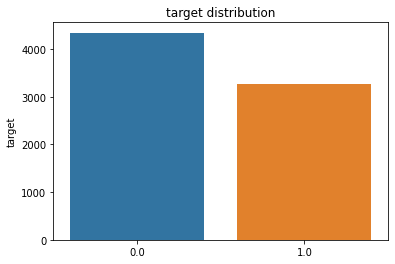

In [0]:
show_target_barplot()

'target' type counts looks to be not too deviated.

In [0]:
# Analyze the keyword & location feature and fil the missing values
def plot_keyword_location():
  fig, ax =plt.subplots(2,1)
  fig.subplots_adjust(hspace=0.1, wspace=0.1)

  target_types = data.keyword.value_counts()[:5]
  # check for first few common names
  plot = sb.barplot(x=target_types, y=data.keyword.value_counts()[:5].index, ax=ax[0])
  plot.set_title('keyword types')

  target_types = data.location.value_counts()[:5]
  plot2 = sb.barplot(x=target_types, y=data.location.value_counts()[:5].index, ax=ax[1])
  plot2.set_title('location types')

  fig.show()

test


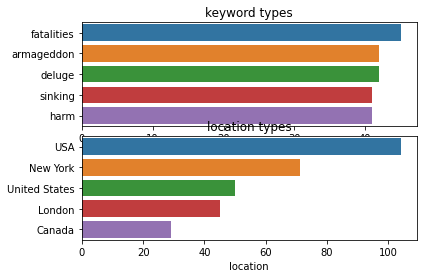

In [0]:
plot_keyword_location()

In [0]:
def fill_misiing_val():
  """ fill missing values with None """
  total_data.location.fillna('None', inplace=True)
  total_data.keyword.fillna('None', inplace=True)

  total_data.target.fillna(0, inplace=True)

fill_misiing_val()

In [0]:
total_data.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [0]:
total_data.head()

,id,keyword,location,text,target
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,None,None,Forest fire near La Ronge Sask. Canada,1.0
2,5,None,None,All residents asked to 'shelter in place' are ...,1.0
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1.0
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1.0


Data is now ready for cleaning

This data is having all weblinks and spaces as well
*   Need to clean the text *data*
*   remove punctuations
*   List item
*   lower case 
*   remove 







In [0]:
def remove_punctuations_and_nums(text):
  """ remove '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' and numbers """
  clean_data = ''.join([x for x in text if x not in string.punctuation])
  clean_data = ''.join([x for x in clean_data if x not in string.digits])
  return clean_data

def remove_stopwords(text):
  clean_data = ''.join([x for x in text if x not in nltk.corpus.stopwords.words('english')])
  return clean_data

def remove_weblinks(text):
  clean_data = re.sub('www.|https://|http://|.com|t.co/','', text)
  return clean_data

def remove_nonascii(text):
  clean_text = ''.join([x for x in text if ord(x) < 128])
  return clean_text


def clean_text(data):
  # convert to lower case
  data['clean_text'] = data['text'].apply(lambda x: x.lower())
  # remove punc & digits
  data['clean_text'] = data['clean_text'].apply(lambda x: remove_punctuations_and_nums(x))
  # remove stopwords
  #data['clean_text'] = data['clean_text'].apply(lambda x: remove_stopwords(x))

  # data['clean_text'] = data['clean_text'].apply(lambda x: remove_weblinks(x)) # takes time
  # remove non ascii charecters
  data['clean_text'] = data['clean_text'].apply(lambda x: remove_nonascii(x))

  data['clean_text'] = data['clean_text'].apply(lambda x: x.strip())


In [0]:
clean_text(total_data)

In [130]:
total_data.head()

,id,keyword,location,text,target,clean_text
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1.0,our deeds are the reason of this earthquake ma...
1,4,None,None,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask canada
2,5,None,None,All residents asked to 'shelter in place' are ...,1.0,all residents asked to shelter in place are be...
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1.0,people receive wildfires evacuation orders in ...
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1.0,just got sent this photo from ruby alaska as s...
